In [118]:
# Imports 
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from IPython.display import Image
import datetime
import os

%matplotlib inline

In [2]:
print(f"np version: {np.__version__}")
print(f"pd version: {pd.__version__}")
print(f"tf version: {tf.__version__}")
print(f"hub version: {hub.__version__}")

# GPU Availaibility
print("GPU", "available" if tf.config.list_physical_devices else "NOT available")

np version: 1.22.4
pd version: 1.3.5
tf version: 2.11.0
hub version: 0.12.0
GPU available


In [3]:
!nvidia-smi

Sat Mar  4 16:39:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data: Loading, preprocessing, exploration

In [9]:
# Check labels
labels_df = pd.read_csv("drive/MyDrive/dog-vision-github/labels.csv")
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
labels_df.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


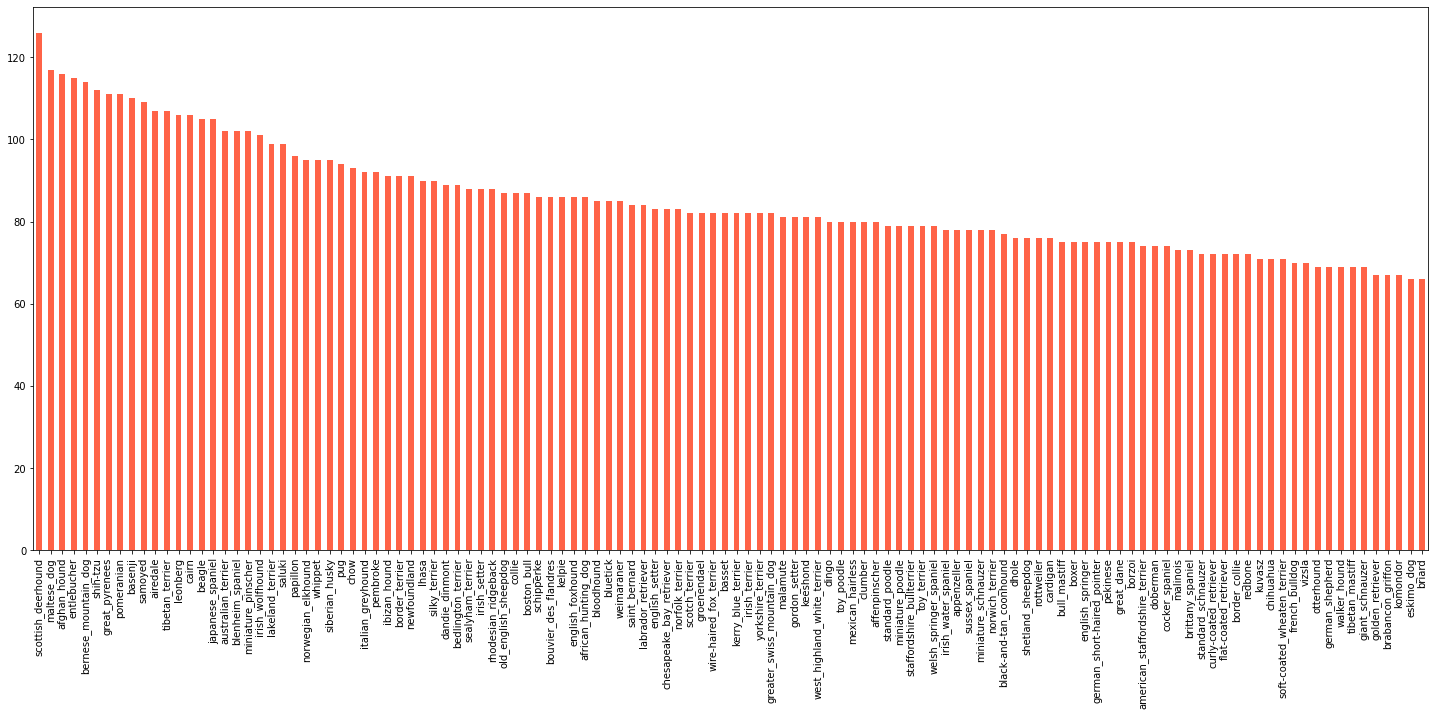

In [16]:
# Image frequencies per class
breed_freq = labels_df["breed"].value_counts()

plt.figure(figsize=(25,10))
breed_freq.plot(kind="bar", color='tomato');

In [17]:
# Median frequency
breed_freq.median() 

82.0

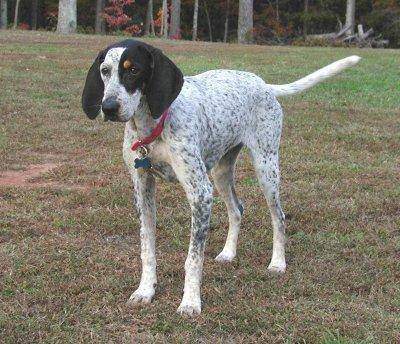

In [20]:
# Explore data
Image("drive/MyDrive/dog-vision-github/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and corrosponding labels

In [23]:
labels_df.sample(5)

,id,breed
8557,d6caade773e0ae660917883ac8520fa4,golden_retriever
3403,549b9df75ad46e33bddfae7628609319,irish_wolfhound
3736,5ce07409cb3d26630c2399bd36f4e20b,irish_terrier
6696,a7fb820b4ca5f9dc6ba8e1a3823cb882,afghan_hound
7010,afc5597e39a5eb338afde2bf75c6a0b2,shih-tzu


In [24]:
# File pathnames from image IDs
filepaths = [f"drive/MyDrive/dog-vision-github/train/{name}.jpg" for name in labels_df.id]
filepaths[:10]

['drive/MyDrive/dog-vision-github/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog-vision-github/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/dog-vision-github/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/dog-vision-github/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/dog-vision-github/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/dog-vision-github/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/dog-vision-github/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/dog-vision-github/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/dog-vision-github/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/dog-vision-github/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

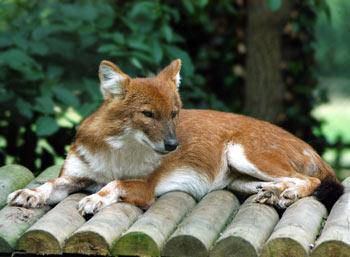

In [26]:
Image(filepaths[42])

In [38]:
# Check if total filepaths matches original file paths
actual_f = os.listdir("drive/MyDrive/dog-vision-github/train/")

if len(actual_f) == len(filepaths):
  print("Original file paths and 'filepaths' match...")
  print(f"Actual: {len(actual_f)}\tCreated: {len(filepaths)}")
else:
  print("Original file paths and 'filepaths' DO NOT match...")
  print(f"Actual: {len(actual_f)}\tCreated: {len(filepaths)}")
  difference = set(actual_f) - set(filepaths)
  print(f"Number of items different: {len(difference)}")

Original file paths and 'filepaths' match...
Actual: 10222	Created: 10222


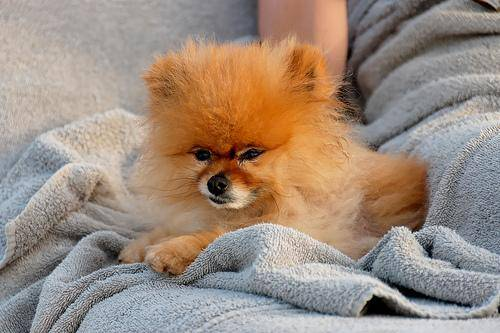

In [49]:
Image(filepaths[8000])

In [50]:
print(labels_df.breed[8000])

pomeranian


In [52]:
# Prepare labels
labels = labels_df["breed"]
labels

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [53]:
# DataFrame to NumPy array
labels.to_numpy()

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [57]:
# Check if total labels matches original file paths
if len(labels) == len(filepaths):
  print("Number of labels match with number of filenames...")
else:
  print("Number of labels does not match with number of filenames...")

Number of labels match with number of filenames...


In [59]:
# Unique breeds
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [60]:
# Test single sample for boolean representation
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [64]:
# Transform every label into boolean representation
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [65]:
# Boolean labels into binary representation
print(f"Original label: {labels[0]}")
print(f"Index where label occurs: {np.where(unique_breeds == labels[0])}")
print(f"Index where label occurs in boolean array: {boolean_labels[0].argmax()}")
print(boolean_labels[0].astype(int))

Original label: boston_bull
Index where label occurs: (array([19]),)
Index where label occurs in boolean array: 19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [66]:
# Another example for previous steps
print(labels[6])
print(boolean_labels[6].astype(int))

bedlington_terrier
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating validation set

In [67]:
# Features and Labels
X = filepaths
y = boolean_labels

In [68]:
NUM_IMAGES = 1000

In [72]:
# Split data of size NUM_IMAGES into train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X[:NUM_IMAGES],
                                                      y[:NUM_IMAGES],
                                                      test_size=0.20,
                                                      random_state=42)

len(X_train), len(X_valid)

(800, 200)

In [76]:
X_train[:2], y_train[:2]

(['drive/MyDrive/dog-vision-github/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/dog-vision-github/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, Fal

### Preprocessing images


In [79]:
img = plt.imread(filepaths[42])
img.shape

(257, 350, 3)

In [81]:
img[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [82]:
# img => tensor
tf.constant(img)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

> To preprocess our images into tensors we are going to write a function which does few things:
>
1. Take an image filepath as an input
2. Use tensorflow to read file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors (numbers)
3. Normalize image (RGB 0-255 into 0-1)
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

Reference: https://www.tensorflow.org/tutorials/load_data/images

In [89]:
IMAGE_SIZE = 224

def process_image(img_fpath, img_size=IMAGE_SIZE):
  """
  Process image by taking an image file input and 
  turns it into a tensor.
  Parameters:
  img_fpath: image file path
  img_size: desired image dimensions
  """
  # Read image file
  image = tf.io.read_file(img_fpath)
  # jpeg into numerical tensor with color channels
  image = tf.image.decode_image(image, channels=3, expand_animations=False)
  # Normalize image 0-255 => 0-1
  image = tf.image.convert_image_dtype(image, dtype='float32')
  # Resize image
  image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

  return image

### Data Batches

> Create data in a form of `Tensor Tuples (X, y)` to use TensorFlow effectively.

Alternatively TensorFlow util [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) can also be used, here function is created manually.
 

In [90]:
# Function to return tuple of tensors
def get_image_label(img_fpath, label):
  """
  Takes an image path and associated label, process the 
  image and return a tensor tuple.
  """
  image = process_image(img_fpath)
  return image, label

In [93]:
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, 
                        y=None, 
                        batch_size=BATCH_SIZE,
                        valid_data=False,
                        test_data=False):
  """
  Create batches of data out of image(X) and label(y) pairs.
  Shuffles data if its training data but doesnt shuffle if its validation data.
  Also accepts test data as input (no labels).
  """
  # Test dataset
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tensors=(tf.constant(X))) 
    data_batch = data.map(map_func=process_image).batch(BATCH_SIZE)
    return data_batch
  
  # Valid dataset, no shuffle 
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices(tensors=(tf.constant(X),  
                                                       tf.constant(y))) 
    data_batch = data.map(map_func=get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  # Train dataset, shuffle
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices(tensors=(tf.constant(X),  
                                                        tf.constant(y))) 
    data = data.shuffle(buffer_size=len(X))
    data = data.map(map_func=get_image_label) 
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [92]:
# Creating Training and Validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [95]:
train_data, valid_data

(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>)

In [98]:
# Check different attributes of data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [99]:
print(f"Train data:\t\t{len(X_train)}")
print(f"Single Training batch:\t{len(train_data)}")
print(f"Batch size: 800 / 25 =\t{800/25}\n")
print(f"25 x 32 = {25*32}")

Train data:		800
Single Training batch:	25
Batch size: 800 / 25 =	32.0

25 x 32 = 800


### Visualize data batches

In [101]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [107]:
# Function to plot 25 images
def plot_25_image_samples(images, labels):
  """
  Displays a plot of 25 images and their labels in data batch.
  """
  plt.figure(figsize=(12,12))
  for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis('off')

In [102]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.04452813, 0.0484497 , 0.05629283],
          [0.05633019, 0.06025176, 0.06809489],
          [0.04290967, 0.04683124, 0.05467437],
          ...,
          [0.07345552, 0.02696446, 0.0128119 ],
          [0.08338569, 0.06167922, 0.02458122],
          [0.09094839, 0.07918368, 0.04653312]],
 
         [[0.03778223, 0.04562537, 0.04161626],
          [0.0300378 , 0.03788094, 0.03387184],
          [0.07026608, 0.07810921, 0.07410011],
          ...,
          [0.2120701 , 0.20385231, 0.15405536],
          [0.06193235, 0.04972087, 0.03209355],
          [0.01333135, 0.00152287, 0.00104142]],
 
         [[0.08905758, 0.10496269, 0.08513601],
          [0.09621842, 0.11212353, 0.09229685],
          [0.05104753, 0.06695264, 0.04712596],
          ...,
          [0.17335822, 0.20798706, 0.14030793],
          [0.3077376 , 0.30949864, 0.20433936],
          [0.37611565, 0.36580402, 0.250109  ]],
 
         ...,
 
         [[0.42239693, 0.37925968, 0.25376946],
          [0.50562

In [103]:
len(train_images), len(train_labels)

(32, 32)

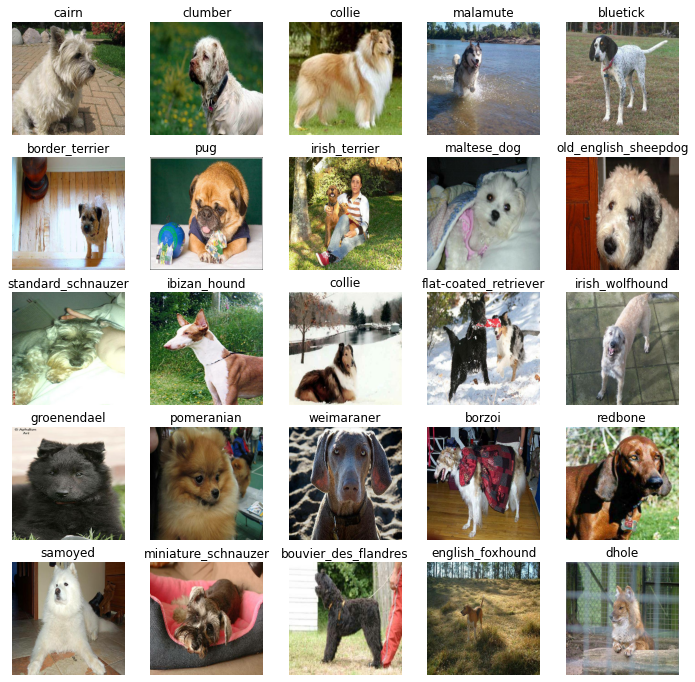

In [108]:
# Visualize train image samples
plot_25_image_samples(train_images, train_labels)

In [110]:
# Visualize validation image samples
valid_images, valid_labels = next(valid_data.as_numpy_iterator())
len(valid_images), len(valid_labels)

(32, 32)

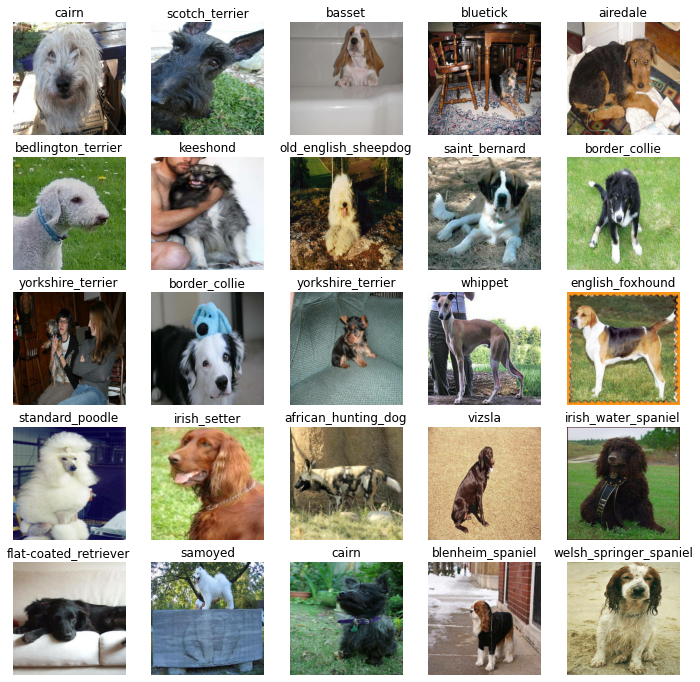

In [111]:
plot_25_image_samples(valid_images, valid_labels)

## Model

* Before building model, we have to follow few steps:
1. Input Shape to our model
2. Outout Shape to our model
3. Choose model from TensorFlow Hub for transfer learning
<hr/>

> We will use `MobileNet V2` for our classification problem.
* URL for this pre-trained model can be found here: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [112]:
# Input, output shape and model url
INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, 3]
OUTPUT_SHAPE = len(unique_breeds) # 120
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [114]:
# Function to build keras model
def create_model(in_shape=INPUT_SHAPE,
                 out_shape=OUTPUT_SHAPE,
                 model_url=MODEL_URL):
  """
  Create, Compile and Build model with pre-trained model.
  """
  print(f"Building model with:\n{model_url}\n")

  # Create model
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL),
      tf.keras.layers.Dense(OUTPUT_SHAPE, activation='softmax')
  ])

  # Compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy']
  )

  # Build model
  model.build(INPUT_SHAPE)

  return model

In [116]:
model = create_model()
model.summary()

Building model with:
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Create Callbacks

> `Callbacks` are helper functions a model can use during training to do such things as save its progress, check its progress or stops training early if a model stops improving.

We will create two callbacks, one for `TensorBoard` which helps track our models progress and another for `early stopping` which prevents our model from training for too long.

#### **TensorBoard Callback**

In [117]:
# Load tensorboard notebook extension
%load_ext tensorboard

In [119]:
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/dog-vision-github/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 
  return tf.keras.callbacks.TensorBoard(log_dir=logdir)

#### **Early Stopping Callback**
> Early stopping will help our model from `overfitting` by stopping training if certain evaluation metric stops improving.

Reference: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [120]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Experimentation

### Train model on a subset of data (~1000 images)

In [121]:
NUM_EPOCHS = 100

In [122]:
# Make sure GPU is availaible
print("GPU", "available" if tf.config.list_physical_devices else "NOT available")

GPU available


In [123]:
# Function to train model 
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  model = create_model()
  tensorboard = create_tensorboard_callback()

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  return model

In [124]:
# Fit model to data
model = train_model()

Building model with:
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

Epoch 1/100
25/25 [==============================] - 21s 236ms/step - loss: 4.5864 - accuracy: 0.0962 - val_loss: 3.5755 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 4s 158ms/step - loss: 1.6566 - accuracy: 0.6850 - val_loss: 2.2769 - val_accuracy: 0.5050
Epoch 3/100
25/25 [==============================] - 5s 188ms/step - loss: 0.5765 - accuracy: 0.9438 - val_loss: 1.7953 - val_accuracy: 0.5800
Epoch 4/100
25/25 [==============================] - 4s 156ms/step - loss: 0.2549 - accuracy: 0.9900 - val_loss: 1.5809 - val_accuracy: 0.6350
Epoch 5/100
25/25 [==============================] - 4s 144ms/step - loss: 0.1460 - accuracy: 0.9987 - val_loss: 1.5001 - val_accuracy: 0.6300
Epoch 6/100
25/25 [==============================] - 4s 138ms/step - loss: 0.0995 - accuracy: 0.9987 - val_loss: 1.4572 - val_accuracy: 0.6450
Epoch 7/100
25/25 [============================

> Our model is `overfitting` as it is performing better on training data but poorly on validation data

In [126]:
# TensorBoard Logs
# %tensorboard --logdir drive/MyDrive/dog-vision-github/logs

## Predictions and Evaluation

In [127]:
valid_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [128]:
# Make predictions on validation data
predictions = model.predict(valid_data, verbose=1)
predictions

7/7 [==============================] - 2s 144ms/step


array([[1.53265556e-03, 2.47682747e-05, 6.47687586e-04, ...,
        2.65512790e-04, 6.18441118e-05, 2.55925488e-03],
       [1.35652104e-03, 4.42869990e-04, 3.93898413e-03, ...,
        2.08790283e-04, 9.99194803e-04, 2.63591763e-04],
       [9.86189625e-05, 3.13327357e-04, 2.94847239e-04, ...,
        3.23446584e-04, 3.95853058e-05, 1.70802604e-03],
       ...,
       [2.94947768e-06, 9.26703142e-05, 3.35460063e-05, ...,
        8.99437418e-06, 2.74914462e-04, 1.34994498e-05],
       [4.70804144e-03, 1.09553075e-04, 6.81087331e-05, ...,
        1.95144385e-04, 2.75302678e-04, 7.65119586e-03],
       [6.34285534e-05, 1.76652175e-05, 9.08253773e-04, ...,
        9.20696743e-03, 3.73248098e-04, 1.40795610e-05]], dtype=float32)

In [129]:
predictions.shape

(200, 120)

In [130]:
len(y_valid), len(unique_breeds)

(200, 120)

In [131]:
# Test on sample for prediction
index = 42
print(predictions[index], '\n')
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[3.53104515e-05 2.29925990e-05 6.01216088e-05 2.43110262e-05
 1.88698515e-03 1.22158730e-04 1.31371911e-04 9.23311163e-04
 6.63064374e-03 3.47709730e-02 4.77018102e-06 9.52136907e-06
 3.06849106e-04 3.45762563e-03 5.49518329e-04 1.14567520e-03
 2.02496831e-05 2.81796703e-04 2.57061911e-04 3.31345684e-04
 6.68241191e-05 2.77198676e-04 3.38957361e-05 6.36269251e-05
 1.29211461e-02 2.75102993e-05 5.88999137e-05 1.01113816e-04
 6.69338260e-05 3.44516229e-05 9.98463511e-05 9.35241842e-05
 7.36850197e-05 7.79095426e-05 1.26774767e-05 3.86032771e-05
 1.79053837e-04 1.42140139e-04 2.27565233e-05 3.07992816e-01
 3.06386937e-04 2.06344066e-05 3.75990593e-03 1.45233544e-05
 2.10598460e-04 1.40907941e-05 1.43402154e-04 1.20660500e-03
 4.64360564e-05 3.63412109e-05 3.66301829e-05 4.00639874e-05
 1.70471540e-04 1.05373771e-03 1.15388366e-05 7.84345320e-05
 1.41948316e-04 7.78182803e-05 1.84792661e-05 7.30853935e-05
 5.46109914e-05 3.42161482e-04 1.41495611e-05 1.75964360e-05
 4.93752341e-05 1.186958

In [132]:
def get_pred_label(pred_probs):
  """
  Turns array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(pred_probs)]

In [133]:
pred_label = get_pred_label(predictions[13])
pred_label

'whippet'

> In order to make predictions we first have to `unbatch` dataset and then compare pred labels with truth labels.

In [134]:
# Create a function to 'unbatch' a batch dataset
def unbatchify(data):
  """
  Takes batched dataset of tensor tuples (X,y) and 
  return unbatch arrays of images and labels.
  """
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

In [135]:
# Unbatchify the validation data
val_images, val_labels = unbatchify(valid_data)

In [136]:
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [137]:
get_pred_label(val_labels[0])

'affenpinscher'

Now we have got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make function to make these all more visual
***
> We will create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and integer. 
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, truth label and the target image on a single plot

In [143]:
def plot_preds(pred_probs, labels, images, n=0):
  """
  View the prediction, ground truth and image for sample n.
  """
  pred_prob, true_label, image = pred_probs[n], labels[n], images[n]
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  # Change the color of title depending on if prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("Prediction: {}\nConfidence: {:.2f}%\nTruth: {}".format(pred_label,
                                                                   np.max(pred_prob)*100,
                                                                   true_label), 
                                                                   color=color)

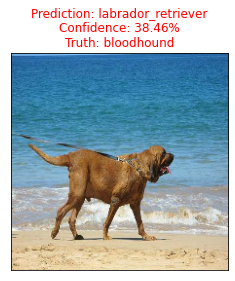

In [159]:
plot_preds(pred_probs=predictions,
           labels=val_labels,
           images=val_images,
           n=100)

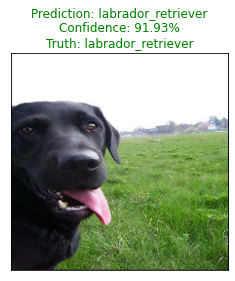

In [165]:
plot_preds(pred_probs=predictions,
           labels=val_labels,
           images=val_images,
           n=40)

#### Visualize top predictions

Now we got one function to visualize our models top predictions, let's make another to view our models top 10 predictions. 

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer.
* Find the prediction using `get_pred_label()`
* Find the top 10:
 * Prediction probabilities index
 * Prediction probabilities values
 * Predcition labels
* Plot the top 10 prediction probability values and labels, coloring true label green

In [166]:
def plot_pred_conf(pred_probs, labels, n=1):
  """
  Plot the top 10 highest prediction confidences along with the
  truth label for sample n.
  """
  pred_prob, true_label = pred_probs[n], labels[n]
  # Get the predicted label
  pred_label = get_pred_label(pred_prob) 
  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]
  # Set up plot
  top_plot = plt.bar(x=np.arange(len(top_10_pred_labels)),
                     height=top_10_pred_values,
                     color="grey")
  plt.xticks(ticks=np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  # Change the color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

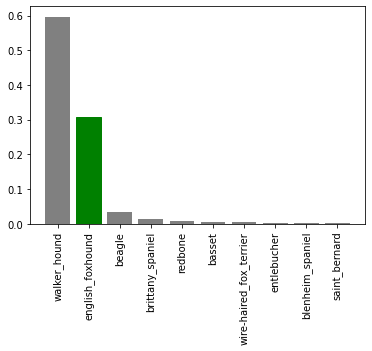

In [167]:
plot_pred_conf(pred_probs=predictions,
               labels=val_labels,
               n=42)

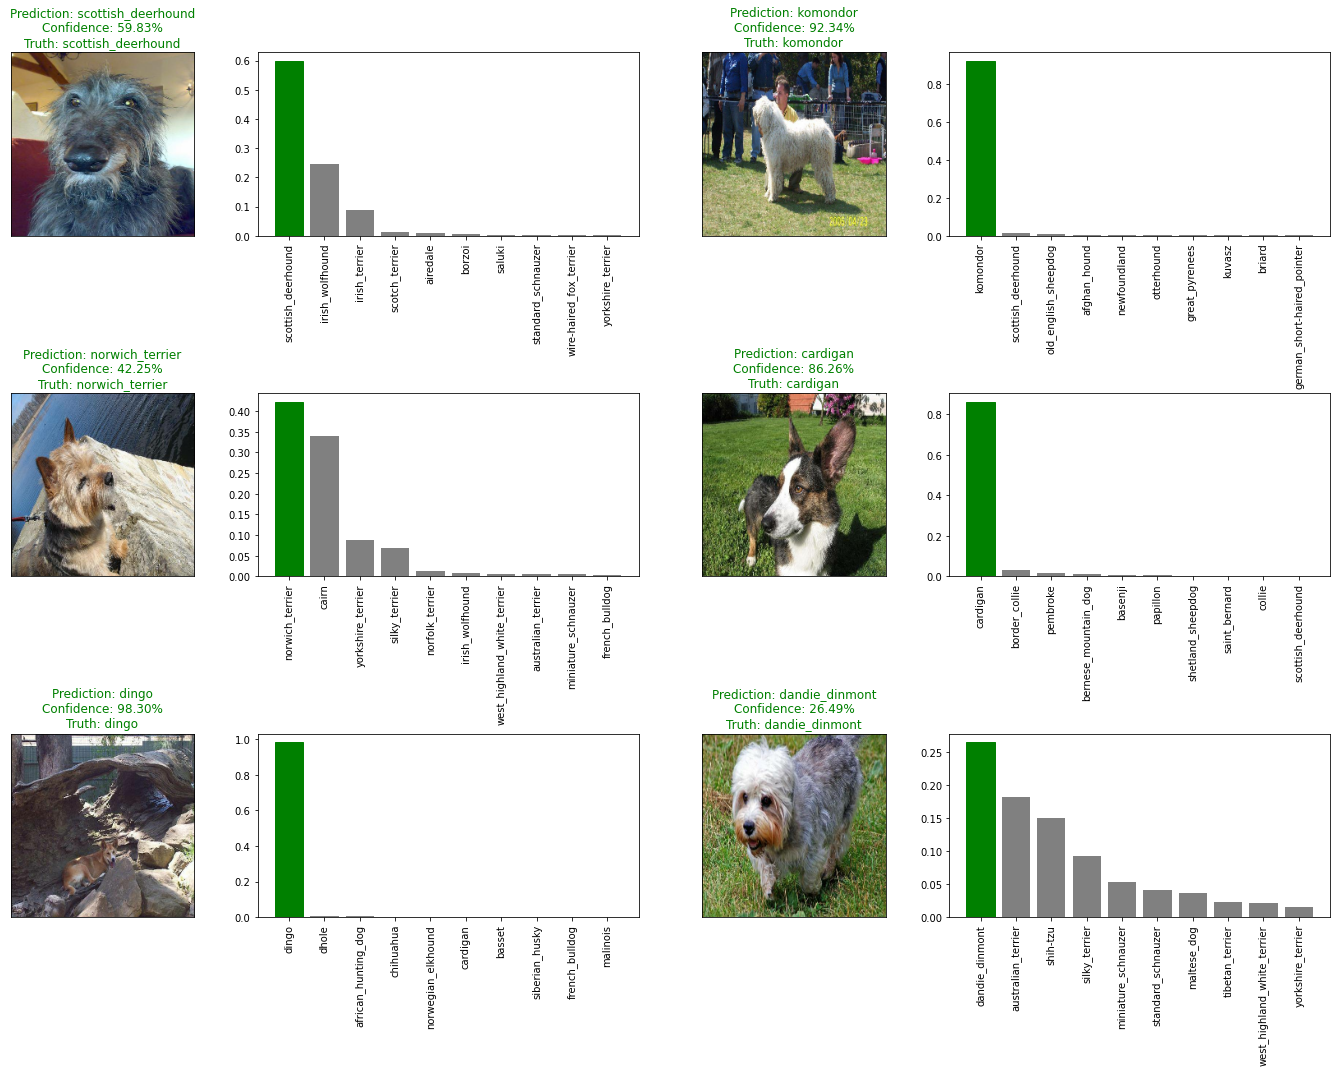

In [168]:
# Check out few predictions and their different values
i_multiplier = 25

num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_preds(pred_probs=predictions,
             labels=val_labels,
             images=val_images,
             n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(pred_probs=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
  plt.tight_layout(h_pad=0.5)

plt.show()

## Save and Reload Model

In [170]:
# Function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in models directory and 
  appends suffix (string).
  """
  # Create model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/dog-vision-github/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = f"{modeldir}-{suffix}.h5" # 
  print(f"Saving model to:\n{model_path}...")
  model.save(filepath=model_path)
  return model_path


# Function to load a model
def load_model(model_path):
  """
  Loads a saved model from specified path.
  """
  print(f"Loading saved model from:\n{model_path}...")
  model = tf.keras.models.load_model(filepath=model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
  return model

In [171]:
# Save our model which is trained on 1000 images
save_model(model=model,
           suffix="1000-images-mobilenetv2-Adam")

Saving model to:
drive/MyDrive/dog-vision-github/models/20230304-19051677956751-1000-images-mobilenetv2-Adam.h5...


'drive/MyDrive/dog-vision-github/models/20230304-19051677956751-1000-images-mobilenetv2-Adam.h5'

In [173]:
# Load our trained model
loaded_1000_image_model = load_model('drive/MyDrive/dog-vision-github/models/20230304-19051677956751-1000-images-mobilenetv2-Adam.h5')

Loading saved model from:
drive/MyDrive/dog-vision-github/models/20230304-19051677956751-1000-images-mobilenetv2-Adam.h5...


In [174]:
# Evaluate the pre-saved model
model.evaluate(valid_data)

7/7 [==============================] - 1s 135ms/step - loss: 1.3484 - accuracy: 0.6750


[1.3483552932739258, 0.675000011920929]

In [175]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(valid_data)

7/7 [==============================] - 2s 108ms/step - loss: 1.3484 - accuracy: 0.6750


[1.3483552932739258, 0.675000011920929]

## Train model on whole dataset

In [176]:
len(X), len(y)

(10222, 10222)

In [177]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)
full_data

Creating training data batches...


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [178]:
# Create a full model
full_model = create_model()

Building model with:
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5



In [179]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", 
                                                             patience=3)

> **Note** : Running a cell below will take a while, (may be upto `30 mins` for the first epoch) because the GPU we are using has to reload all of the images into the memory.

In [180]:
# Fit the full model to full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 48s 126ms/step - loss: 1.3425 - accuracy: 0.6695
Epoch 2/100
320/320 [==============================] - 38s 118ms/step - loss: 0.3989 - accuracy: 0.8815
Epoch 3/100
320/320 [==============================] - 38s 119ms/step - loss: 0.2391 - accuracy: 0.9345
Epoch 4/100
320/320 [==============================] - 36s 113ms/step - loss: 0.1553 - accuracy: 0.9634
Epoch 5/100
320/320 [==============================] - 38s 117ms/step - loss: 0.1063 - accuracy: 0.9792
Epoch 6/100
320/320 [==============================] - 38s 119ms/step - loss: 0.0775 - accuracy: 0.9859
Epoch 7/100
320/320 [==============================] - 36s 114ms/step - loss: 0.0586 - accuracy: 0.9906
Epoch 8/100
320/320 [==============================] - 36s 112ms/step - loss: 0.0455 - accuracy: 0.9949
Epoch 9/100
320/320 [==============================] - 38s 118ms/step - loss: 0.0374 - accuracy: 0.9962
Epoch 10/100
320/320 [==============================] - 39s 122m

In [181]:
full_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_3 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [182]:
save_model(model=full_model, 
           suffix="full-image-set-mobilenetv2-Adam")

Saving model to:
drive/MyDrive/dog-vision-github/models/20230304-19191677957548-full-image-set-mobilenetv2-Adam.h5...


'drive/MyDrive/dog-vision-github/models/20230304-19191677957548-full-image-set-mobilenetv2-Adam.h5'

In [184]:
# Loading full model
loaded_full_model = load_model(model_path="drive/MyDrive/dog-vision-github/models/20230304-19191677957548-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from:
drive/MyDrive/dog-vision-github/models/20230304-19191677957548-full-image-set-mobilenetv2-Adam.h5...


## Making prediction on test dataset

Since our model have been trained on images in the form of tensor batches, to make predictions on test data, we will have to get it into the same format.

> We already have function `create_data_batches()` which can take a list of filenames as an input and convert them into `tensor bacthes`.

To make predictions on the test data, we will:
* Get the test image filenames ✅
* Convert the filenames into test data batches using `create_data_batches()`✅
* Make predictions array by passing the test data batches.

In [185]:
# Load test image filenames
test_path = "drive/MyDrive/dog-vision-github/test/"
test_filenames = [f"{test_path}{fname}" for fname in os.listdir(test_path)]
test_filenames[:5]

['drive/MyDrive/dog-vision-github/test/000621fb3cbb32d8935728e48679680e.jpg',
 'drive/MyDrive/dog-vision-github/test/00102ee9d8eb90812350685311fe5890.jpg',
 'drive/MyDrive/dog-vision-github/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'drive/MyDrive/dog-vision-github/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'drive/MyDrive/dog-vision-github/test/001a5f3114548acdefa3d4da05474c2e.jpg']

In [186]:
len(test_filenames)

10357

In [187]:
# Create test data batch
test_data = create_data_batches(X=test_filenames, 
                                test_data=True)

test_data

Creating test data batches...


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [188]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(x=test_data,
                                             verbose=1)

324/324 [==============================] - 62s 188ms/step


In [189]:
# Save predictions (NumPy array) to csv file (for later access)
np.savetxt("drive/MyDrive/dog-vision-github/preds_array.csv", test_predictions, delimiter=",")

In [190]:
# Load predictions from csv file
test_predictions = np.loadtxt("drive/MyDrive/dog-vision-github/preds_array.csv", delimiter=",")

In [191]:
test_predictions[:10]

array([[1.14623519e-10, 2.32464534e-10, 3.86843823e-13, ...,
        2.81315596e-12, 6.47714282e-09, 1.39512429e-10],
       [9.99346412e-06, 1.39279575e-06, 8.69456116e-08, ...,
        8.79108175e-11, 2.71782653e-07, 6.89827173e-09],
       [2.57092458e-10, 3.34737706e-06, 4.70849955e-08, ...,
        2.81282337e-06, 4.46656268e-09, 8.22476254e-10],
       ...,
       [3.41443389e-08, 1.06369191e-09, 2.70675793e-09, ...,
        6.21587504e-11, 8.77396905e-11, 2.11432694e-09],
       [6.26384555e-10, 8.79489281e-09, 1.58594049e-09, ...,
        1.59197480e-05, 1.83114793e-07, 6.76885381e-10],
       [3.42504265e-08, 5.04139508e-10, 1.28134636e-09, ...,
        6.50915346e-12, 1.06305541e-10, 1.81649546e-06]])

In [192]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking at Kaggle sample submission, we find that it wants our model's prediction probability outputs in a DataFrame with an ID and column for each different dog breed.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

> To get the data in this format we will :
* Create pandas DataFrame with an ID column as well as a column for each dog breed ✅
* Add data to the ID column by extracting the test image IDs from their filepaths 
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as csv to submit it to Kaggle.

In [193]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [194]:
# Append test image IDs to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids[:5]

['000621fb3cbb32d8935728e48679680e',
 '00102ee9d8eb90812350685311fe5890',
 '0012a730dfa437f5f3613fb75efcd4ce',
 '001510bc8570bbeee98c8d80c8a95ec1',
 '001a5f3114548acdefa3d4da05474c2e']

In [195]:
preds_df["id"] = test_ids

In [196]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00102ee9d8eb90812350685311fe5890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012a730dfa437f5f3613fb75efcd4ce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001510bc8570bbeee98c8d80c8a95ec1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001a5f3114548acdefa3d4da05474c2e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,1.146235e-10,2.324645e-10,3.868438e-13,2.248493e-12,5.898420e-12,2.100490e-10,7.924804e-15,6.674282e-12,8.886583e-13,...,5.612392e-12,3.829458e-12,1.588850e-12,3.097523e-13,1.284517e-12,3.539436e-11,5.774765e-12,2.813156e-12,6.477143e-09,1.395124e-10
1,00102ee9d8eb90812350685311fe5890,9.993464e-06,1.392796e-06,8.694561e-08,4.940713e-09,1.864270e-06,1.419594e-07,2.147854e-06,1.408148e-06,4.537385e-08,...,9.611711e-08,6.345230e-07,9.867438e-09,1.530095e-05,4.959637e-08,6.369044e-07,3.843139e-04,8.791082e-11,2.717827e-07,6.898272e-09
2,0012a730dfa437f5f3613fb75efcd4ce,2.570925e-10,3.347377e-06,4.708500e-08,1.216873e-09,1.124194e-09,1.138868e-07,4.257951e-10,1.961897e-11,6.750984e-08,...,1.873785e-10,1.013074e-10,1.039806e-07,4.282051e-06,1.942624e-07,8.692427e-08,2.040172e-10,2.812823e-06,4.466563e-09,8.224763e-10
3,001510bc8570bbeee98c8d80c8a95ec1,8.095454e-07,1.464183e-06,1.360191e-06,5.165965e-06,9.057136e-05,7.723454e-07,2.664958e-10,4.693566e-09,2.293558e-07,...,2.730555e-07,5.275455e-10,5.088007e-07,3.511198e-09,1.354549e-07,1.200848e-09,6.158146e-14,1.827898e-03,1.221788e-10,5.818224e-08
4,001a5f3114548acdefa3d4da05474c2e,2.800018e-04,2.255701e-05,9.035465e-08,7.609840e-09,1.552869e-08,1.104895e-10,5.423642e-09,2.207034e-08,4.210667e-08,...,3.688082e-07,4.431123e-10,2.786686e-09,1.238374e-09,3.926276e-09,2.252569e-09,7.008771e-10,5.686124e-07,2.107923e-09,3.085557e-07


In [198]:
# Save our predictions DataFrame to CSV for submission to Kaggle
preds_df.to_csv("drive/MyDrive/dog-vision-github/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

In [199]:
# Get custom image filepaths
custom_path = "drive/MyDrive/dog-vision-github/my-dog-images/"
custom_image_paths = [f"{custom_path}{fname}" for fname in os.listdir(custom_path)]

custom_image_paths

['drive/MyDrive/dog-vision-github/my-dog-images/test1.jpeg',
 'drive/MyDrive/dog-vision-github/my-dog-images/test4.jpeg',
 'drive/MyDrive/dog-vision-github/my-dog-images/test2.jpeg',
 'drive/MyDrive/dog-vision-github/my-dog-images/test3.jpeg',
 'drive/MyDrive/dog-vision-github/my-dog-images/test5.jpeg']

In [201]:
custom_data_batch = create_data_batches(X=custom_image_paths,
                                        test_data=True)
custom_data_batch

Creating test data batches...


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [203]:
# Make predictions on custom data 
custom_preds = loaded_full_model.predict(custom_data_batch)

1/1 [==============================] - 1s 630ms/step


In [204]:
custom_preds.shape

(5, 120)

In [205]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['pug', 'eskimo_dog', 'maltese_dog', 'pomeranian', 'miniature_pinscher']

In [206]:
custom_images = []

for image in custom_data_batch.unbatch().as_numpy_iterator():
  custom_images.append(image)

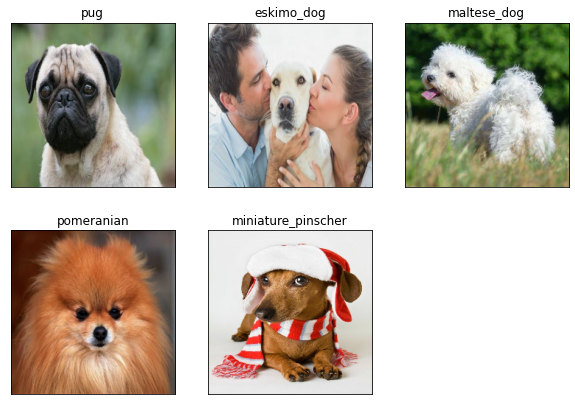

In [211]:
# Check custom image predictions
plt.figure(figsize=(10,7))
for i, image in enumerate(custom_images):
  plt.subplot(2, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)